# 0) Building TF using tides 

## a) Load data

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import time


import importlib
from data import data_management
importlib.reload(data_management)


config = {"general":{"db_update": False,
                     "db_path": "D:/OneDrive/database/",
                     "output": "telegram/"},
          "strategy": {"instruments":[
                                      "ftx_BTC/USD",
                                      # "SGX_TWN1!",
                                      # "ftx_ETH/USD",
                                      # "ftx_SOL/USD",
                                      # "ftx_FTT/USD",
                                      # "ftx_FTM/USD",
                                      # "ftx_TSM/USD",
                                      # "ftx_NVDA/USD",
                                      # "ftx_AMD/USD",
                                      # "ftx_TSLA/USD",
                                      ],
                       "timeframes": ["1h","2h","3h","4h","6h","12h","24h"],
                       "indicators": {'ema': {'length': [5,8,13,21,34,55], 'price': ['close']}, 
                                      'mfi': {'length': [5,8,13,21,34,55]},
                                      'rsi': {'length': [5,8,13,21,34,55], 'price':['low', 'high']},
                                      'tide': {'window': [12,24,72], "sensitivity": [90], "thresholds": [10]},
                                      
                                      # 'slopes': {'slope_lengths':[7,10,14,20,28,40,56,80],
                                      #           'scaling_factor':[1],
                                      #           'lookback':[500],
                                      #            'logRet_norm_window':[10],
                                      #           'upper_quantile':[0.9]}
                                      },
                       "resample": True
                      },

          }



data_manager = data_management.DataManager(instruments = config["strategy"]["instruments"],
                           db_path = config["general"]["db_path"],
                           update_db = config["general"]["db_update"],
                           timeframes = config["strategy"]["timeframes"],
                           indicators = config["strategy"]["indicators"],
                           resample = config["strategy"]["resample"],
                           )

klines_indicators_dict =  data_manager.load_data()

for instrument,df in klines_indicators_dict.items():
    print(f"{instrument}: {df.index[0]} ----> {df.index[-1]}, len: {len(df)}")
    
df0 = klines_indicators_dict[config["strategy"]["instruments"][0]]

[X] Strategy requires the following argument(s):
 - ta. Format is a list of dicts. Example: [{'kind': 'sma', 'length': 10}]
       Check the indicator for the correct arguments if you receive this error.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.14s/it]

ftx_BTC/USD: 2019-10-06 21:00:00 ----> 2022-07-28 08:00:00, len: 24612


long winrate: 0.497 | short winrate: 0.484
long gains: 789.74 | long pains: -743.89
short gains: 792.1 | short pains: -764.1
B: 77.83% | A: 175.4% | L: 147.4% | S: 128.0%
total # of trades: 3973.0 | hours/trade: 3.4636
Time taken: 0.07779s for 13761 rows


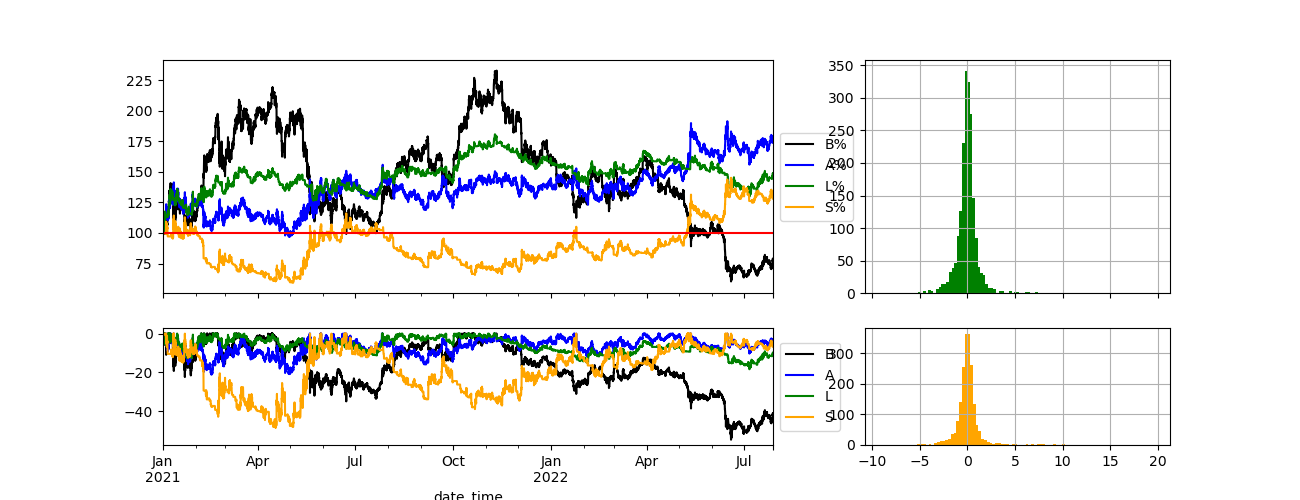

In [8]:
%matplotlib widget
import importlib
from backtest import backtest
importlib.reload(backtest)
df0_backtest,df0_trades = backtest.backtest(df0.rename(columns={"4h_tide":"Y"})["2021-01-01":],signals=["Y"])

In [10]:
import importlib
from plots import plotly_studies
importlib.reload(plotly_studies)

ps = plotly_studies.build(cols_to_plot = [["cum_long_pnl",
                                           "cum_short_pnl",
                                           "cum_buyhold"],["OHLC_1h",
                                           'long_entry_price',
                                           'long_exit_price',
                                           'short_entry_price',
                                           'short_exit_price',"1h_ebb","1h_flow"],"Y","1h_tidestr"], row_heights = [1,2,1,1], height=1000,width=1000)
ps.plot(df0_backtest["2021-08-18":"2021-08-30"])

plotting: ['cum_long_pnl', 'cum_short_pnl', 'cum_buyhold']
plotting: ['cum_long_pnl', 'cum_short_pnl', 'cum_buyhold'] --> LIST DETECTED
plotting: ['OHLC_1h', 'long_entry_price', 'long_exit_price', 'short_entry_price', 'short_exit_price', '1h_ebb', '1h_flow']
plotting: ['OHLC_1h', 'long_entry_price', 'long_exit_price', 'short_entry_price', 'short_exit_price', '1h_ebb', '1h_flow'] --> LIST DETECTED
plotting: Y
Y -> cat data detected
plotting: 1h_tidestr


FigureWidgetResampler({
    'data': [{'name': 'cum_long_pnl',
              'type': 'scattergl',
             …

# 1) Preprocessing

## a) Feature Engineering

In [16]:
# from darts.models import KalmanForecaster
def build_features(df_original):
    df=df_original.copy()
    tfs = [i.split("_")[0] for i in list(df.filter(regex="high"))]
    """
    x-y, x-y, x-y, 
    for y in [high, low, close]
    for x in [open, ebb, flow] for all timeframes
    """
    closeTimes = list(df.filter(regex="closeTime").columns)
    ohlc = list(df.filter(regex="(_open$)|(_high$)|(_low$)|(_close$)").columns)
    tides = list(df.filter(regex="tide$").columns)
    mfis = list(df.filter(regex="MFI").columns)
    ebbs = list(df.filter(regex="ebb").columns)
    rsis = list(df.filter(regex="RSI").columns)
    emas = []# list(df.filter(regex="EMA").columns)
#     df1 = df[[f"{tf}_close" for tf in tfs] +closeTimes +tides+mfis].copy() #+emas
    df1 = df[ohlc +closeTimes +ebbs +mfis+emas+tides + rsis].copy() #+emas
    # df1["slopes"] = np.where(df["1h_slope_avg_500_10"]>df["1h_slope_u_500_10"],1,0)  + np.where(df["1h_slope_avg_500_10"]<df["1h_slope_l_500_10"],-1,0)
    # for tide in tides:
    #     df1[tide] = df1[tide].astype("int")
    for mfi in mfis:
        df[mfi] = df[mfi]/100
        
    df1["tides"]=df.filter(regex="tide").mean(axis=1)
    temp_deltas ={}
    
    
    # Deltas of features with OHLC in timeframes
    for tf in tfs:
        # temp_deltas[f"{tf}_ebb_delta"] =  df[f"{tf}_ebb"].pct_change()
        for x in ["open","high", "low", "close"]:
            for y in ["ebb"]:#, "EMA_14", "EMA_39", "EMA_81"]:
                temp_deltas[f"{tf}_{x}_{y}"] = df[f"{tf}_{x}"] - df[f"{tf}_{y}"]
                # temp_deltas[f"{tf}_{x}_{y}_avg"] = df[[f"{tf}_{x}",f"{tf}_{y}"]].mean(axis=1)
                
    # Inter timeframes features and their deltas
    for i in range(0,len(tfs)):
        for j in range(i):
            # print(f"{tfs[i]}_{tfs[j]}")
            temp_deltas[f"{tfs[j]}_{tfs[i]}_ebb"] = df[f"{tfs[j]}_ebb"] - df[f"{tfs[i]}_ebb"] 
            # temp_deltas[f"{tfs[j]}_{tfs[i]}_ebb_delta"] = temp_deltas[f"{tfs[j]}_{tfs[i]}_ebb"].diff()
            
            temp_deltas[f"{tfs[j]}_{tfs[i]}_MFI"] = df[f"{tfs[j]}_MFI_13"] - df[f"{tfs[i]}_MFI_13"] 
            # temp_deltas[f"{tfs[j]}_{tfs[i]}_MFI_delta"] = temp_deltas[f"{tfs[j]}_{tfs[i]}_MFI"].diff()
            # df1[f"{tfs[j]}_{tfs[i]}_flow"] = df[f"{tfs[j]}_flow"] - df[f"{tfs[i]}_flow"] 
#     df1["1h_4h_ebb"] = df["1h_ebb"]-df["4h_ebb"]
#     df1["1h_24h_ebb"] = df["1h_ebb"]-df["24h_ebb"]
#     df1["4h_24h_ebb"] = df["4h_ebb"]-df["24h_ebb"]
#     df1["4h_48h_ebb"] = df["4h_ebb"]-df["48h_ebb"]      
    df1 = pd.concat([df1,pd.DataFrame(temp_deltas)],axis=1)
    print(f"Features: \n{df1.columns}")
    return df1
df1 = build_features(df0)    

Features: 
Index(['1h_open', '1h_high', '1h_low', '1h_close', '2h_open', '2h_high',
       '2h_low', '2h_close', '3h_open', '3h_high',
       ...
       '2h_24h_ebb', '2h_24h_MFI', '3h_24h_ebb', '3h_24h_MFI', '4h_24h_ebb',
       '4h_24h_MFI', '6h_24h_ebb', '6h_24h_MFI', '12h_24h_ebb', '12h_24h_MFI'],
      dtype='object', length=246)


## b) Build labels
Triple barrier with 4 parameters          
    - time barrier          
    - vol lookback (for thresholds)          
    - multiplier for thresholds (upper_z, lower_z)

In [35]:
# from strategy import labels
# import importlib
# importlib.reload(labels)
# df_labelled = labels.calc_triple_barrier(df1,
#                                          col_series="1h_ebb",
#                                          col_timestamps = "1h_closeTime",
#                                          horizon_delta = 12,
#                                          vol_span = 4,
#                                          upper_z = 1,
#                                          lower_z = -1,
#                                          resample= None)
# # df_labelled["label"].replace(0, np.NaN, inplace=True)
# # df_labelled["label"].fillna(method="ffill",inplace=True)
# print(f"labels: {df_labelled['label'].unique()}")
# This has best ost performace so far but low accuracy! 


from strategy import labels
import importlib
importlib.reload(labels)
df_labelled = labels.calc_triple_barrier(df1,
                                         col_series="1h_ebb",
                                         col_timestamps = "1h_closeTime",
                                         horizon_delta = 12,
                                         vol_span = 3,
                                         upper_z = 2,
                                         lower_z = -2,
                                         resample= None)

df_labelled["label"].replace(0, np.NaN, inplace=True)
df_labelled["label"].fillna(method="bfill",inplace=True)
print(f"labels: {df_labelled['label'].unique()}")

24593it [00:10, 2237.18it/s]

labels: [-1.  1. nan]


## c) Feature/ Label Analysis


Label engineering:    
Need labels to comply with trends, need rules:    
- 

### i) Perfect Trades Analysis (for labels)

long winrate: 0.975 | short winrate: 0.99
long gains: 2072.94 | long pains: -5.02
short gains: 1736.59 | short pains: -0.97
B: 272.27% | A: 3905.58% | L: 2169.96% | S: 1835.63%
total # of trades: 572.0 | hours/trade: 42.9948
Time taken: 0.08927s for 24593 rows


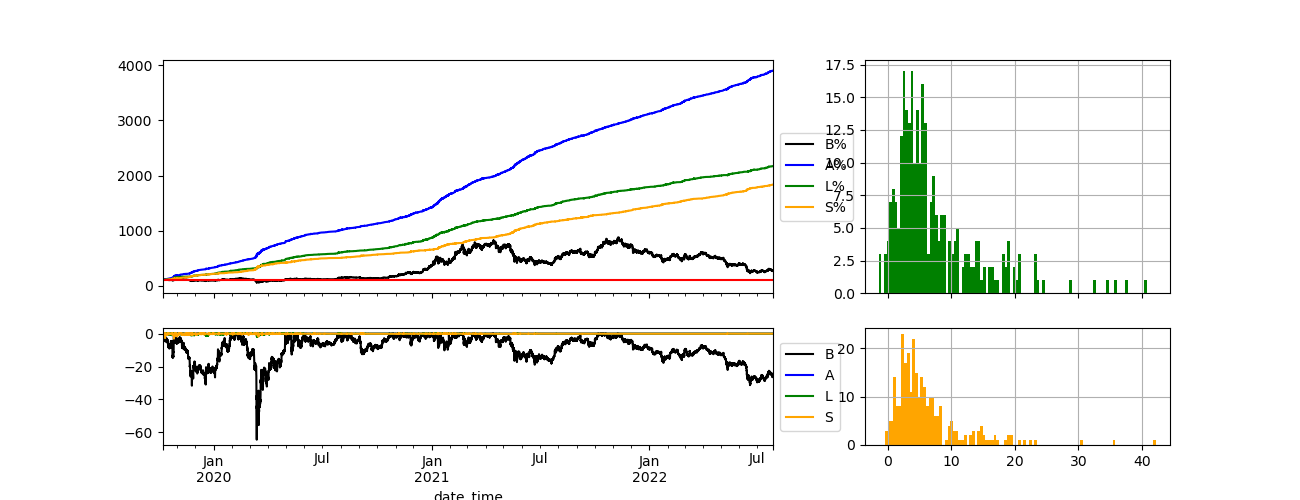

In [36]:
%matplotlib widget
import importlib
from backtest import backtest
importlib.reload(backtest)
df_label,trades_label = backtest.backtest(df_labelled.rename(columns={"label":"Y"}),signals=["Y"],trd_fees=0, slippage=0)

In [47]:
import importlib
from plots import plotly_studies
importlib.reload(plotly_studies)
# df_label["tides_ema"]=df_label["tides"].ewm(span=12).mean()
# df_label["tides_delta"]=df_label["tides_ema"].diff()
feature = "ebb"
prices=["close","high","low"]

tide_labels = []
for price in prices:
    for tf in config["strategy"]["timeframes"]:
        tide_labels.append(f"{tf}_{price}_{feature}")

test = []
for tide_label in tide_labels:
    df_label[f"{tide_label}_binary"]=np.where(df_label[tide_label]>0,1,-1)
    test.append(f"{tide_label}_binary")
# df_label["high_ebbs"]=

# df_label["1h_ebb_max"]=df_label["1h_ebb"].rolling(12).max().shift(1)
# df_label["1h_ebb_min"]=df_label["1h_ebb"].rolling(12).min().shift(1)
df_label["1h_ebb_long"] = df_label["1h_ebb"].pct_change()
df_label["1h_ebb_long"] = df_label[df_label["1h_ebb_long"]>=0]["1h_ebb_long"]
# df_label["1h_ebb_long"]  = df_label[df_label["1h_ebb_long"] >0]["1h_ebb_long"].rolling(12).sum()
df_label["1h_ebb_short"] = df_label["1h_ebb"].pct_change()
df_label["1h_ebb_short"] = df_label[df_label["1h_ebb_short"]<=0]["1h_ebb_short"]

df_label["Y1"]=np.where(df_label["1h_3h_ebb"]>0,1,-1)
# df_label["tides_up"] = df_label["tides_ema"]-df_label["tides_max"]
# df_label["tides_down"] = df_label["tides_min"]-df_label["tides_ema"]
# df_label["tides_breakout"] = df_label["tides_up"] + df_label["tides_down"]
# df_label["tides_label"]=df_label["tides_delta"]+
ps = plotly_studies.build(cols_to_plot = [["cum_long_pnl",
                                           "cum_short_pnl"],
                                          ["1h_ebb_long","1h_ebb_short"],
                                          ["1h_high_ebb_binary"],
                                          ["OHLC_1h",
                                          'long_entry_price',
                                          'long_exit_price',
                                          'short_entry_price',
                                          'short_exit_price',
                                          "1h_ebb","2h_ebb","4h_ebb"],
                                          "Y1",
                                          "Y",
                                          "2h_tide",
                                          "1h_RSI_13_l",
                                          "1h_MFI_13"
                                         ], row_heights = [1,2,1,3,1,1,1,1,1], height=1000,width=1000)
ps.plot(df_label['2021-07-01':'2021-12-31']) #["2022-07-01":"2022-07-27"]
#[["1h_4h_ebb_delta"],["1h_4h_ebb"],["OHLC_1h","1h_ebb","2h_ebb","4h_ebb"],["1h_MFI_13","2h_MFI_13"]]

plotting: ['cum_long_pnl', 'cum_short_pnl']
plotting: ['cum_long_pnl', 'cum_short_pnl'] --> LIST DETECTED
plotting: ['1h_ebb_long', '1h_ebb_short']
plotting: ['1h_ebb_long', '1h_ebb_short'] --> LIST DETECTED
plotting: ['1h_high_ebb_binary']
plotting: ['1h_high_ebb_binary'] --> LIST DETECTED
['1h_high_ebb_binary'] -> cat data detected
plotting: ['OHLC_1h', 'long_entry_price', 'long_exit_price', 'short_entry_price', 'short_exit_price', '1h_ebb', '2h_ebb', '4h_ebb']
plotting: ['OHLC_1h', 'long_entry_price', 'long_exit_price', 'short_entry_price', 'short_exit_price', '1h_ebb', '2h_ebb', '4h_ebb'] --> LIST DETECTED
plotting: Y1
Y1 -> cat data detected
plotting: Y
Y -> cat data detected
plotting: 2h_tide
2h_tide -> cat data detected
plotting: 1h_RSI_13_l
plotting: 1h_MFI_13


FigureWidgetResampler({
    'data': [{'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~4…

In [72]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
target = "tides_delta"
df_label1 = df_label.dropna(subset=[target,"Y"])
f1 = f1_score(df_label1["Y"], df_label1[target])
f1=np.round(f1,3)
accuracy = accuracy_score(df_label1["Y"], df_label1[target])
accuracy=np.round(accuracy,3)
recall = recall_score(df_label1["Y"], df_label1[target])
recall=np.round(recall,3)
precision = precision_score(df_label1["Y"], df_label1[target])
precision=np.round(precision,3)
print("Baseline Model\nAccuracy: ", accuracy, "\nf1_score: ",f1, "\nprecision: ",precision,"\nrecall: ",recall)

Baseline Model
Accuracy:  0.62 
f1_score:  0.631 
precision:  0.639 
recall:  0.623


D:\Users\Shaik Reza Shafiq\Desktop\Tide\backtest\backtest.py:839: RuntimeWarning:

invalid value encountered in longlong_scalars



long winrate: 1.0 | short winrate: nan
long gains: 56.33 | long pains: 0.0
short gains: 0.0 | short pains: 0.0
B: 132.14% | A: 140.94% | L: 140.94% | S: 100.0%
total # of trades: 2.0 | hours/trade: 2208.0
Time taken: 0.01596s for 4416 rows


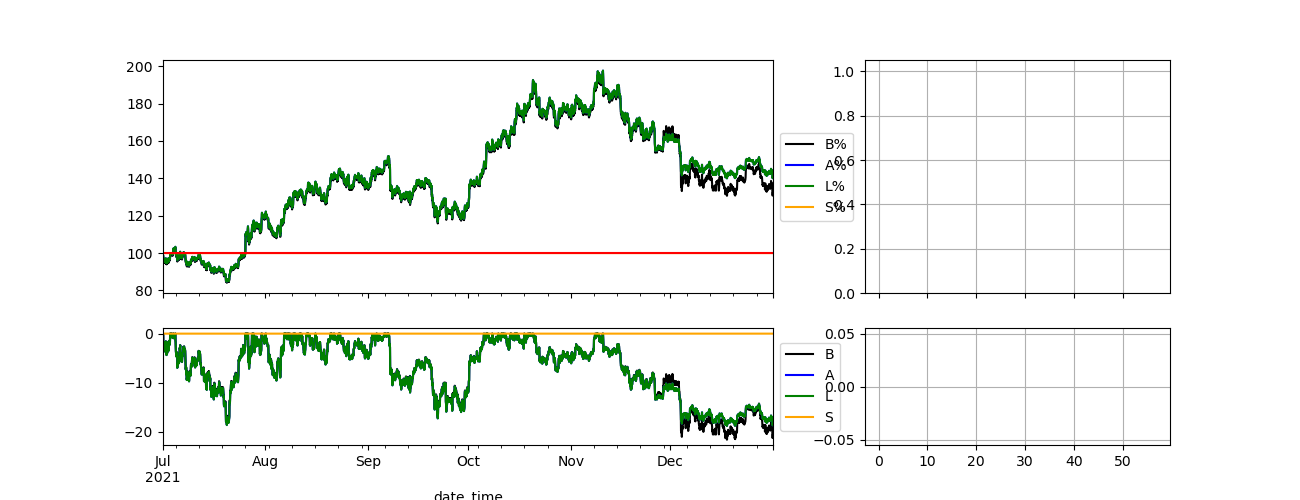

In [9]:
%matplotlib widget
import importlib
from backtest import backtest
importlib.reload(backtest)
df_label,trades_label = backtest.backtest(df_labelled.rename(columns={"1h_MFI_13":"Y"})['2021-07-01':'2021-12-31'],signals=["Y"],trd_fees=0, slippage=0)

In [96]:
df_labelled.filter(regex="ebb").columns

Index(['1h_ebb', '4h_ebb', '6h_ebb', '12h_ebb', '24h_ebb', '1h_ebb_delta',
       '1h_open_ebb', '1h_high_ebb', '1h_low_ebb', '1h_close_ebb',
       '4h_ebb_delta', '4h_open_ebb', '4h_high_ebb', '4h_low_ebb',
       '4h_close_ebb', '6h_ebb_delta', '6h_open_ebb', '6h_high_ebb',
       '6h_low_ebb', '6h_close_ebb', '12h_ebb_delta', '12h_open_ebb',
       '12h_high_ebb', '12h_low_ebb', '12h_close_ebb', '24h_ebb_delta',
       '24h_open_ebb', '24h_high_ebb', '24h_low_ebb', '24h_close_ebb',
       '1h_4h_ebb', '1h_6h_ebb', '4h_6h_ebb', '1h_12h_ebb', '4h_12h_ebb',
       '6h_12h_ebb', '1h_24h_ebb', '4h_24h_ebb', '6h_24h_ebb', '12h_24h_ebb'],
      dtype='object')

# 2) Baseline: CATBOOST

In [87]:
import pandas as pd
import tensorflow as tf
import autokeras as ak

# 3) Transformer

In [1]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

## a) Preprocessing

TOTAL window: 2019-10-06 21:00:00 ----> 2022-07-27 13:00:00, len: 24593
TRAIN window: 2020-01-01 00:00:00 ----> 2021-12-31 23:00:00, len: 17544
TEST window: 2022-01-01 00:00:00 ----> 2022-07-27 13:00:00, len: 4982

labels:
['label']
features: 
['1h_ebb', '2h_ebb', '3h_ebb', '4h_ebb', '6h_ebb', '12h_ebb', '24h_ebb', '1h_MFI_5', '1h_MFI_8', '1h_MFI_13', '1h_MFI_21', '1h_MFI_34', '1h_MFI_55', '2h_MFI_5', '2h_MFI_8', '2h_MFI_13', '2h_MFI_21', '2h_MFI_34', '2h_MFI_55', '3h_MFI_5', '3h_MFI_8', '3h_MFI_13', '3h_MFI_21', '3h_MFI_34', '3h_MFI_55', '4h_MFI_5', '4h_MFI_8', '4h_MFI_13', '4h_MFI_21', '4h_MFI_34', '4h_MFI_55', '6h_MFI_5', '6h_MFI_8', '6h_MFI_13', '6h_MFI_21', '6h_MFI_34', '6h_MFI_55', '12h_MFI_5', '12h_MFI_8', '12h_MFI_13', '12h_MFI_21', '12h_MFI_34', '12h_MFI_55', '24h_MFI_5', '24h_MFI_8', '24h_MFI_13', '24h_MFI_21', '24h_MFI_34', '24h_MFI_55', '1h_RSI_5_l', '1h_RSI_5_h', '1h_RSI_8_l', '1h_RSI_8_h', '1h_RSI_13_l', '1h_RSI_13_h', '1h_RSI_21_l', '1h_RSI_21_h', '1h_RSI_34_l', '1h_RSI_

array([<AxesSubplot:label='C', title={'center':'label'}>], dtype=object)

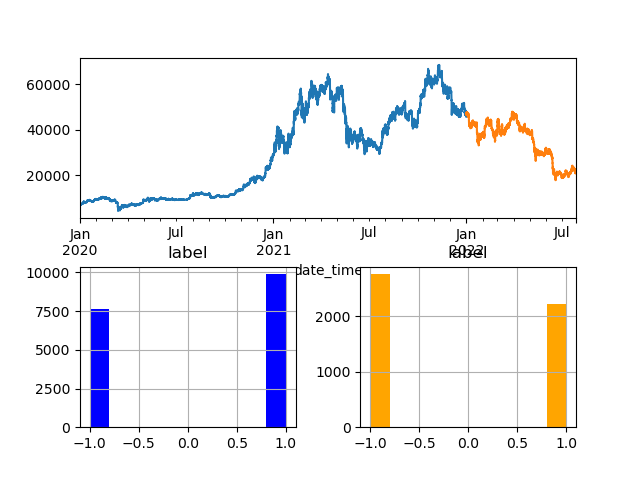

In [33]:
import numpy as np
train_window = ["2020-01-01",'2021-12-31']
test_window = ['2022-01-01','2022-12-31']
df = df_labelled.drop(columns=['t', 't1']).copy()
# df= df.filter(regex="(1h)|(label)")

features = list(df.filter(regex="(MFI)|(ebb)|(RSI)")) #|(MFI)|(EMA)|(tidex$)
labels = ['label'] 

df_train= df[train_window[0]:train_window[1]].copy()
df_test = df[test_window[0]:test_window[1]].copy()

print(f"TOTAL window: {df.index[0]} ----> {df.index[-1]}, len: {len(df)}")
print(f"TRAIN window: {df_train.index[0]} ----> {df_train.index[-1]}, len: {len(df_train)}")
print(f"TEST window: {df_test.index[0]} ----> {df_test.index[-1]}, len: {len(df_test)}")

print(f"\nlabels:\n{labels}\nfeatures: \n{features}")


%matplotlib widget
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic("AA;BC")
df_train["1h_close"].plot(ax=axs["A"])
df_test["1h_close"].plot(ax=axs["A"])
# df["1h_close"][test_window[1]:].plot(ax=axs["A"])
df_train[labels].hist(ax=axs["B"], color="blue")
df_test[labels].hist(ax=axs["C"],color="orange")
# df[test_window[1]:][labels].hist(ax=axs["D"],color="green")
# label_train = df_train[labels].value_counts()

In [34]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  # MinMaxScaler

train_features = df_train[features]
train_labels = df_train[labels]

test_features = df_test[features]
test_labels =  df_test[labels]

scaler = StandardScaler()  # MinMaxScaler(feature_range=(-1,1))
scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
                                     index=train_features.index,
                                     columns=train_features.columns)
# The Scaler is fit on the training set and then applied to the test set
scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
                                    index=test_features.index,
                                    columns=test_features.columns)



x_train = scaled_train_features.values
x_test = scaled_test_features.values

y_train = train_labels.values
y_test = test_labels.values

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape} \nx_test_shape : {x_test.shape} , y_test_shape : {y_test.shape}")
print(f"y labels: {np.unique(y_train)}")

x_train shape: (17544, 203, 1), y_train shape: (17544, 1) 
x_test_shape : (4982, 203, 1) , y_test_shape : (4982, 1)
y labels: [0. 1.]


## b) Build network

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape, # Number of features
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
        
    outputs = layers.Dense(2, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [28]:
input_shape = x_train.shape[1:]

model = build_model(
                    input_shape,
                    head_size=256,
                    num_heads=4,
                    ff_dim=4,
                    num_transformer_blocks=4,
                    mlp_units=[128],
                    mlp_dropout=0.4,
                    dropout=0.25,
                    )

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 203, 1)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 203, 1)      2           ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 203, 1)      7169        ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

## c) Train network

Epoch 1/100
165/165 [==============================] - 33s 168ms/step - loss: 0.7214 - sparse_categorical_accuracy: 0.6199 - val_loss: 0.6727 - val_sparse_categorical_accuracy: 0.6398
Epoch 2/100
165/165 [==============================] - 31s 188ms/step - loss: 0.6543 - sparse_categorical_accuracy: 0.6515 - val_loss: 0.6749 - val_sparse_categorical_accuracy: 0.6409
Epoch 3/100
165/165 [==============================] - 31s 189ms/step - loss: 0.6244 - sparse_categorical_accuracy: 0.6761 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.6436
Epoch 4/100
165/165 [==============================] - 31s 186ms/step - loss: 0.6084 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.6593 - val_sparse_categorical_accuracy: 0.6420
Epoch 5/100
165/165 [==============================] - 31s 186ms/step - loss: 0.5917 - sparse_categorical_accuracy: 0.6942 - val_loss: 0.6676 - val_sparse_categorical_accuracy: 0.6466
Epoch 6/100
165/165 [==============================] - 29s 173ms/step - loss: 0.

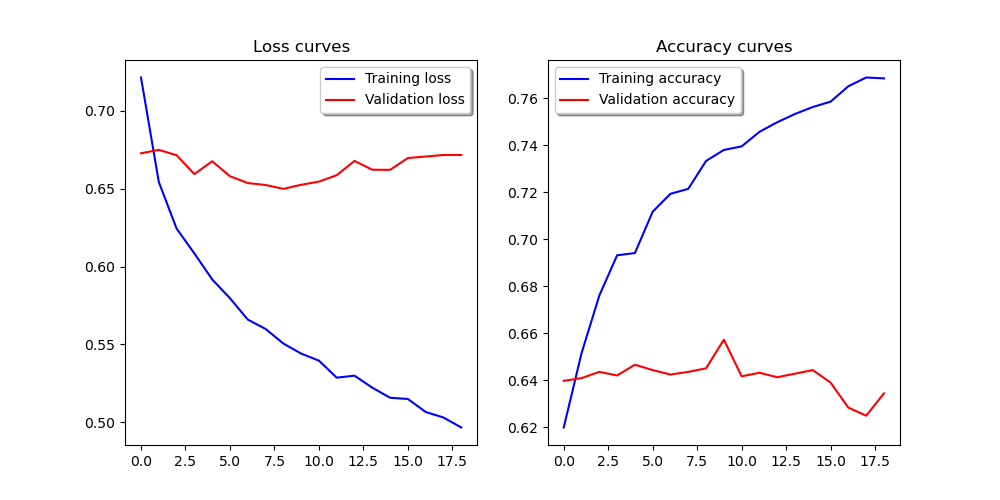

In [29]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
                    x_train,
                    y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64, # Try for different batch sizes, past 64 hours good enough???
                    callbacks=callbacks,
                )

#  EVALUATE

# Evaluate the model:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=1)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)


%matplotlib widget
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * x_test.shape[0])} out of {x_test.shape[0]} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['sparse_categorical_accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_sparse_categorical_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [30]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [172]:
from tensorflow import keras
new_model = keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 126, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 126, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 126, 1)      7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

## d) Backtest

138/138 [==============================] - 5s 30ms/step
long winrate: 0.268 | short winrate: 0.284
long gains: 202.84 | long pains: -197.25
short gains: 144.58 | short pains: -177.8
B: 132.14% | A: 72.37% | L: 105.59% | S: 66.78%
total # of trades: 656.0 | hours/trade: 6.7317
Time taken: 0.01895s for 4416 rows


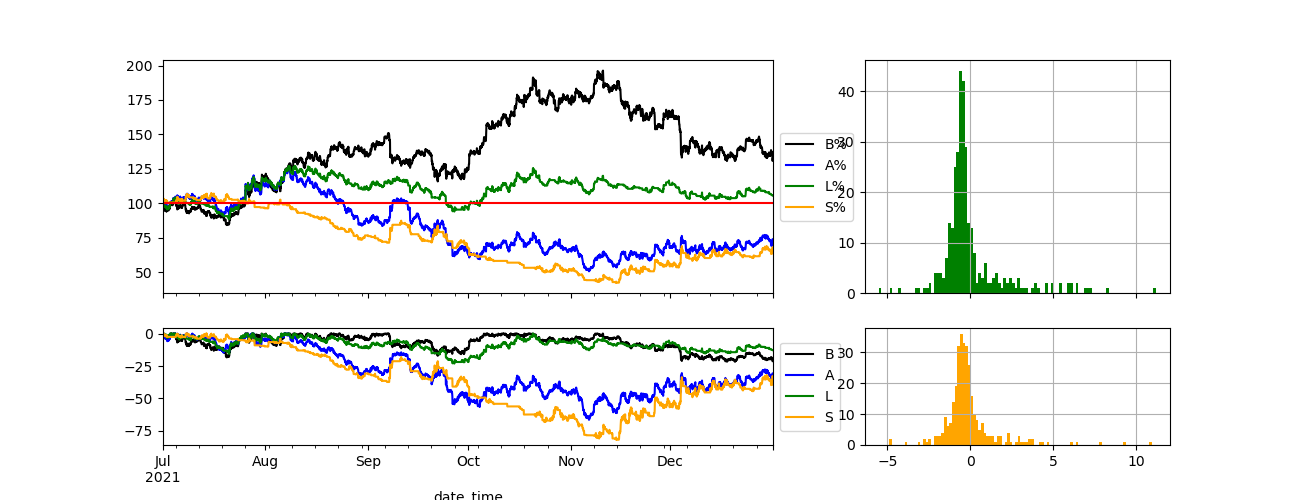

In [31]:
pred = model.predict(x_test, verbose=1)
df_OST = df_labelled [test_window[0]:test_window[1]].copy().dropna()
# df_OST["Y"] = pred
df_OST["Y"] = np.where(pred[:,1] >0.5,1,0) +  np.where(pred[:,0] >0.5,-1,0)
df_OST["p"] = pred[:,0]
df_OST.dropna()
%matplotlib widget
import importlib
from backtest import backtest
importlib.reload(backtest)
df_ost,trades_ost = backtest.backtest(df_OST, signals=["Y","p"])

## e) Trades Analysis

In [39]:
import importlib
from plots import plotly_studies
importlib.reload(plotly_studies)

ps = plotly_studies.build(cols_to_plot = [["cum_long_pnl",
                                           "cum_short_pnl",
                                           "cum_buyhold"],["OHLC_1h",
                                           'long_entry_price',
                                           'long_exit_price',
                                           'short_entry_price',
                                           'short_exit_price'],"Y","p",labels[0]], row_heights = [1,2,1,1,1], height=1000,width=1000)
ps.plot(df_ost)

plotting: ['cum_long_pnl', 'cum_short_pnl', 'cum_buyhold']
plotting: ['cum_long_pnl', 'cum_short_pnl', 'cum_buyhold'] --> LIST DETECTED
plotting: ['OHLC_1h', 'long_entry_price', 'long_exit_price', 'short_entry_price', 'short_exit_price']
plotting: ['OHLC_1h', 'long_entry_price', 'long_exit_price', 'short_entry_price', 'short_exit_price'] --> LIST DETECTED
plotting: Y
Y -> cat data detected
plotting: p
plotting: label
label -> cat data detected


FigureWidgetResampler({
    'data': [{'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~4…

138/138 [==============================] - 2s 12ms/step
long winrate: 0.769 | short winrate: 0.5
long gains: 86.53 | long pains: -41.15
short gains: 19.45 | short pains: -60.42
B: 132.14% | A: 105.47% | L: 146.44% | S: 59.03%
total # of trades: 56.0 | hours/trade: 78.8571
Time taken: 0.03391s for 4416 rows


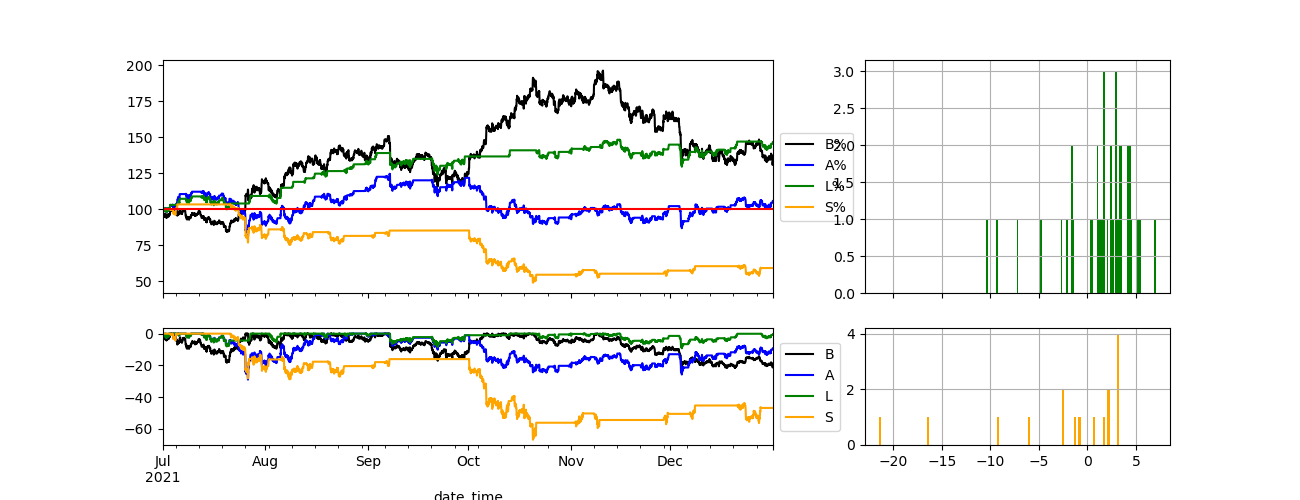

In [134]:
pred = model.predict(x_test, verbose=1)
df_OST = df_labelled [test_window[0]:test_window[1]].copy().dropna()
# df_OST["Y"] = pred
df_OST["Y"] = np.where(pred[:,1] >0.5,1,0) +  np.where(pred[:,0] >0.5,-1,0)
df_OST["p"] = pred[:,1]
df_OST.dropna()
%matplotlib widget
import importlib
from backtest import backtest
importlib.reload(backtest)
df_ost,trades_ost = backtest.backtest(df_OST, signals=["Y","p"])